# Using Transfer learning to classify Digits 5 to 9 

The goal of this project is to try and reuse pretrained layers of a DNN to classify digits 5 to 9 using a small subset of MNIST dataset (500 images, 100 per class). We aim to show that transfer learning helps to train models in situations where only a small dataset is available.
We reuse parts of the model trained to classify digits 0 to 4 of MNIST. Training is done using Tensorflow's low-level API.
Steps involved include THE FOLLOWING LISTED BELOW:
* Download and preprocess MNIST dataset
* Reuse all 5 hidden layers to train new model. The layers to reuse are frozen and their output cached
* Reuse only the first two hidden layers and see if performance improves. Here also, the reused layers are frozen and their output cached
* Try building new model from scratch

#### Import libraries we are going to use

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
%matplotlib inline

#### Download and preprocess MNIST dataset

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


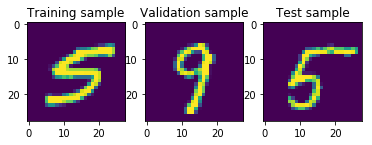

In [2]:
#load dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

#digits 5 to 9 are mapped as follows: 5->0,6->1,7->2,8->3,9->4
#extract digits 5 to 9 of training dataset (100 for each class)
id5 = np.random.permutation(np.nonzero(mnist.train.labels == 5)[0])[:100]
id6 = np.random.permutation(np.nonzero(mnist.train.labels == 6)[0])[:100]
id7 = np.random.permutation(np.nonzero(mnist.train.labels == 7)[0])[:100]
id8 = np.random.permutation(np.nonzero(mnist.train.labels == 8)[0])[:100]
id9 = np.random.permutation(np.nonzero(mnist.train.labels == 9)[0])[:100]
train_index_5_9 = np.hstack((id5,id6,id7,id8,id9))
mnist_train_images_5_9 = mnist.train.images[train_index_5_9] 
mnist_train_labels_5_9 = mnist.train.labels[train_index_5_9] - 5

#extract digits 5 to 9 of validation dataset
valid_index_5_9 = np.nonzero(mnist.validation.labels >= 5)[0]
mnist_valid_images_5_9 = mnist.validation.images[valid_index_5_9]
mnist_valid_labels_5_9 = mnist.validation.labels[valid_index_5_9] - 5

#extract digits 5 to 9 of test dataset
test_index_5_9 = np.nonzero(mnist.test.labels >= 5)[0]
mnist_test_images_5_9 = mnist.test.images[test_index_5_9]
mnist_test_labels_5_9 = mnist.test.labels[test_index_5_9] - 5

#display a sample of training, validation and test images
plt.subplot(131)
plt.imshow(mnist_train_images_5_9[98].reshape(28,28))
plt.title('Training sample')
plt.subplot(132)
plt.imshow(mnist_valid_images_5_9[120].reshape(28,28))
plt.title('Validation sample')
plt.subplot(133)
plt.imshow(mnist_test_images_5_9[75].reshape(28,28))
plt.title('Test sample')
plt.show()

#### Reuse all five hidden layers
Build new DNN to classify digits 5 to 9 by reusing all five hidden layers of model trained to claasify digits 0 to 4

In [3]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')

reuse_vars_dict = {}    
#define variables to save and restore
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="hidden[12345]")
for var in reuse_vars:
    print(var.name)
    reuse_vars_dict[var.op.name] = var

#Saver object for restoring variables
original_saver = tf.train.Saver(reuse_vars_dict)

#define variables to train
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='logits')
    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the new model
new_saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


hidden1/kernel:0
hidden1/bias:0
hidden2/kernel:0
hidden2/bias:0
hidden3/kernel:0
hidden3/bias:0
hidden4/kernel:0
hidden4/bias:0
hidden5/kernel:0
hidden5/bias:0


In [4]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize all variables
    original_saver.restore(sess,'./saved_models/model_0_4_final.ckpt') #restore variables to reuse
    
    #cache output from frozen layers
    shuffle_idx = np.random.permutation(mnist_train_labels_5_9.shape[0])
    hidden5_output = sess.run(hidden5,feed_dict={X:mnist_train_images_5_9})[shuffle_idx]
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        hidden5_output_batches = np.array_split( hidden5_output,batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffle_idx],batch_size)
        for hidden5_output_batch,y_batch in zip(hidden5_output_batches,y_batches):
            sess.run(training_op,feed_dict={hidden5:hidden5_output_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={hidden5:hidden5_output_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        new_saver.save(sess,'./saved_models/model_5_9.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    new_saver.save(sess,'./saved_models/model_5_9_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
500 Training Accuracy: 1.0 Validation Accuracy: 0.735463
1000 Training Accuracy: 1.0 Validation Accuracy: 0.780508
1500 Training Accuracy: 1.0 Validation Accuracy: 0.799345
2000 Training Accuracy: 1.0 Validation Accuracy: 0.809582
2500 Training Accuracy: 1.0 Validation Accuracy: 0.816134
3000 Training Accuracy: 1.0 Validation Accuracy: 0.820639
3500 Training Accuracy: 1.0 Validation Accuracy: 0.822277
4000 Training Accuracy: 1.0 Validation Accuracy: 0.825962
4500 Training Accuracy: 1.0 Validation Accuracy: 0.826372
5000 Training Accuracy: 1.0 Validation Accuracy: 0.827191
5500 Training Accuracy: 1.0 Validation Accuracy: 0.825962
6000 Training Accuracy: 1.0 Validation Accuracy: 0.822277
6500 Training Accuracy: 1.0 Validation Accuracy: 0.821458
7000 Training Accuracy: 1.0 Validation Accuracy: 0.81982
7500 Training Accuracy: 1.0 Validation Accuracy: 0.818182
8000 Training Accuracy: 1.0 Validation Accuracy: 0.817

In [5]:
# Let's evaluate accuracy of model on test dataset
with tf.Session() as sess:
    #restore saved model
    new_saver.restore(sess,'./saved_models/model_5_9_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_final.ckpt
Test Accuracy: 0.810327


In [6]:
# Let's do some predictions on the test dataset using our model
with tf.Session() as sess:
    new_saver.restore(sess,'./saved_models/model_5_9_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[330:335]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[330:335] + 5)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_final.ckpt
Prediction: [8 7 7 7 7]
Target: [8 5 7 7 7]


Can we get better accuracy reusing only the first two hidden layers?

#### Reusing first two hidden layers

In [7]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')

reuse_vars_dict = {}    
#define variables to save and restore
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="hidden[12]")
for var in reuse_vars:
    print(var.name)
    reuse_vars_dict[var.op.name] = var

#Saver object for restoring variables
original_saver = tf.train.Saver(reuse_vars_dict)

#define variables to train
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='hidden[345]|logits')
    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the new model
new_saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


hidden1/kernel:0
hidden1/bias:0
hidden2/kernel:0
hidden2/bias:0


In [8]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize all variables
    original_saver.restore(sess,'./saved_models/model_0_4_final.ckpt') #restore variables to reuse
    
    #cache output from frozen layers
    shuffle_idx = np.random.permutation(mnist_train_labels_5_9.shape[0])
    hidden2_output = sess.run(hidden2,feed_dict={X:mnist_train_images_5_9})[shuffle_idx]
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        hidden2_output_batches = np.array_split( hidden2_output,batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffle_idx],batch_size)
        for hidden2_output_batch,y_batch in zip(hidden2_output_batches,y_batches):
            sess.run(training_op,feed_dict={hidden2:hidden2_output_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={hidden2:hidden2_output_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        new_saver.save(sess,'./saved_models/model_5_9_with_reuse_2layers.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    new_saver.save(sess,'./saved_models/model_5_9_with_reuse_2layers_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
500 Training Accuracy: 1.0 Validation Accuracy: 0.865684
1000 Training Accuracy: 1.0 Validation Accuracy: 0.867322
1500 Training Accuracy: 1.0 Validation Accuracy: 0.888206
2000 Training Accuracy: 1.0 Validation Accuracy: 0.872236
2500 Training Accuracy: 1.0 Validation Accuracy: 0.845209
3000 Training Accuracy: 1.0 Validation Accuracy: 0.886159
3500 Training Accuracy: 1.0 Validation Accuracy: 0.90172
4000 Training Accuracy: 1.0 Validation Accuracy: 0.884111
4500 Training Accuracy: 1.0 Validation Accuracy: 0.882473
5000 Training Accuracy: 1.0 Validation Accuracy: 0.863227
5500 Training Accuracy: 1.0 Validation Accuracy: 0.872645
6000 Training Accuracy: 1.0 Validation Accuracy: 0.891073
6500 Training Accuracy: 1.0 Validation Accuracy: 0.914414
7000 Training Accuracy: 1.0 Validation Accuracy: 0.909091
7500 Training Accuracy: 1.0 Validation Accuracy: 0.896806
8000 Training Accuracy: 1.0 Validation Accuracy: 0.898

In [9]:
# Let's evaluate accuracy of model on test dataset
with tf.Session() as sess:
    #restore saved model
    new_saver.restore(sess,'./saved_models/model_5_9_with_reuse_2layers_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_with_reuse_2layers_final.ckpt
Test Accuracy: 0.908455


In [10]:
# Let's do some predictions on the test dataset using our model
with tf.Session() as sess:
    new_saver.restore(sess,'./saved_models/model_5_9_with_reuse_2layers_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[330:335]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[330:335] + 5)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_with_reuse_2layers_final.ckpt
Prediction: [8 5 7 7 7]
Target: [8 5 7 7 7]


Looks like by reusing only the first two hidden layers, we are able to train a more accurate model than when we reuse all the five hidden layers. Can we even do better training the model from scratch?

#### Training DNN from scratch to classify digits 5 to 9

In [11]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')

    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the new model
saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


In [12]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize all variables
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        shuffle_idx = np.random.permutation(mnist_train_labels_5_9.shape[0])
        x_batches = np.array_split(mnist_train_images_5_9[shuffle_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffle_idx],batch_size)
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={X:x_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        saver.save(sess,'./saved_models/model_5_9_from_scratch.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    saver.save(sess,'./saved_models/model_5_9_from_scratch_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.0 Validation Accuracy: 0.802211
1000 Training Accuracy: 1.0 Validation Accuracy: 0.853399
1500 Training Accuracy: 1.0 Validation Accuracy: 0.86855
2000 Training Accuracy: 1.0 Validation Accuracy: 0.898034
2500 Training Accuracy: 1.0 Validation Accuracy: 0.916462
3000 Training Accuracy: 1.0 Validation Accuracy: 0.900082
3500 Training Accuracy: 1.0 Validation Accuracy: 0.816953
4000 Training Accuracy: 1.0 Validation Accuracy: 0.895577
4500 Training Accuracy: 1.0 Validation Accuracy: 0.864865
5000 Training Accuracy: 1.0 Validation Accuracy: 0.921376
5500 Training Accuracy: 1.0 Validation Accuracy: 0.879607
6000 Training Accuracy: 1.0 Validation Accuracy: 0.914824
6500 Training Accuracy: 1.0 Validation Accuracy: 0.911138
7000 Training Accuracy: 1.0 Validation Accuracy: 0.91769
7500 Training Accuracy: 1.0 Validation Accuracy: 0.914414
8000 Training Accuracy: 1.0 Validation Accuracy: 0.914414
8500 Training Accuracy: 1.0 Validation Accuracy: 0.922195
9000 Training Acc

In [13]:
# Let's evaluate accuracy of model on test dataset
with tf.Session() as sess:
    #restore saved model
    saver.restore(sess,'./saved_models/model_5_9_from_scratch_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_from_scratch_final.ckpt
Test Accuracy: 0.912775


In [14]:
# Let's do some predictions on the test dataset using our model
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_5_9_from_scratch_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[330:335]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[330:335] + 5)

INFO:tensorflow:Restoring parameters from ./saved_models/model_5_9_from_scratch_final.ckpt
Prediction: [8 5 7 7 7]
Target: [8 5 7 7 7]


It seems in this case training from scratch gives us the best accuracy

#### Conclusion

We have seen that through transfer learning, we are able to train a new model with just a small dataset. While this gives us quite remarkable accuracy, training from scratch seems to perform better. Nevertheless transfer learning could prove extremely useful in cases where we are training a model to perform a complex task using a small dataset